In [81]:
import numpy as np
import pandas as pd
import scanpy as sc
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
import statistics as st
import anndata as ad
from src.functions import *
%matplotlib inline

In [82]:
dataset_co_cult = np.load('data/Mx_Co_Cultured/marks_flitered_fluo.npy', allow_pickle = True)

dict_headers = ["norm_MM",
    "cell_marks",
    "nucl_fluo",
    "cell_fluo",
    "marks_fluo",
    "marks_cell_overlap",
    "mark_area",
    "overlap_indices",
    "marks_fluo_overlap",
    "cell_area",
    "marks_cell_overlap_indexes",
    "marks_cellLabels",
    "marks_samplingArea",
    "pmi",
    "overLaps"]

cell_area = dataset_co_cult[9]

# reference, which cells are covered by which marks
cell_marks = dataset_co_cult[1]

# size of every mark
mark_area = dataset_co_cult[6]

# reference of overlap area between cells and marks
marks_cell_overlap = dataset_co_cult[5]



In [83]:
# pickles of tables that result from this comfiguration have suffix "_small"
if(False):
    selected_cells = ['3', '100', '21', '43', '547']
    cell_marks = {k:v for k,v in cell_marks.items() if k in selected_cells}
    marks_cell_overlap = {k:v for k,v in marks_cell_overlap.items() if k in selected_cells}
    selected_pixels = ['2']
    for _, cell in cell_marks.items():
        selected_pixels = selected_pixels + [str(n) for n in cell]

    selected_pixels.sort(key = int)
    mark_area = {k:v for k,v in mark_area.items() if k in selected_pixels}

    selected_pixels

In [84]:
# calculating different cell x pixel matrices
overlap_matrix, sampling_prop_matrix, sampling_spec_matrix = get_matrices(mark_area=mark_area, marks_cell_associations=cell_marks, marks_cell_overlap=marks_cell_overlap)
sampling_spec_matrix

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_2490,pixel_2491,pixel_2492,pixel_2493,pixel_2494,pixel_2495,pixel_2496,pixel_2497,pixel_2498,pixel_2499
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:

ion_intensities = pd.read_csv('data/Mx_Co_Cultured/sm_annotation_detections.csv')

ion_intensities = ion_intensities.drop(['Num', 'X', 'Y', 'Z', 'R'], axis=1)

# ion_intensities = ion_intensities[['C16H30O2', "C25H44NO7P", "C45H78NO8P"]]
# ion_intensities = ion_intensities.iloc[selected_pixels]

ion_intensities.index = [PIXEL_PRE + str(i) for i in ion_intensities.index]
ion_intensities


,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
pixel_0,11732.452,996.42834,0.000000,96.63648,251.41237,1035.7161,508.46760,776.2968,728.43120,1268.3046,...,263.37576,252.51741,0.0,244.01695,0.00000,99.36901,0.0,2732.2040,1450.11540,128.282870
pixel_1,8926.941,644.85220,98.860180,94.53568,129.45300,1127.7477,660.01980,798.9810,499.13810,1126.1990,...,269.30545,126.23382,0.0,491.70282,340.28522,75.63770,0.0,4471.3240,1770.75710,400.891660
pixel_2,16184.508,1443.74080,122.435680,459.26910,298.34604,874.1114,869.47440,1570.6218,1599.04420,1897.0496,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,970.5054,616.07654,78.222760
pixel_3,17386.785,1770.08830,0.000000,521.62244,392.64360,1581.3160,851.89560,1496.8848,1700.58310,2238.6267,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,1037.3005,702.37850,0.000000
pixel_4,17993.777,2441.13100,0.000000,424.59857,589.03710,1536.0576,1004.76526,1373.1233,1684.19860,2142.4817,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,1332.7043,940.42100,120.620830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel_2495,14193.198,1098.00960,377.735440,133.33331,0.00000,1268.6356,966.20984,1225.4326,1056.80550,2004.0934,...,130.08005,229.90854,0.0,136.83795,0.00000,0.00000,0.0,4241.5864,1591.95830,317.245880
pixel_2496,17826.373,2204.89750,124.410450,604.37280,635.19990,1172.6652,2027.87210,2225.9185,2475.11870,3223.1426,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,2617.0530,1362.17570,85.987526
pixel_2497,20524.766,2208.07860,131.849640,535.55316,437.42600,1162.7046,1485.94580,1914.0786,1891.50900,3095.1462,...,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.0,3441.5498,2130.13530,101.250000
pixel_2498,13827.365,1398.90610,117.092980,228.95663,93.65218,922.5511,1030.80410,1423.4183,1002.28130,2138.9333,...,184.42477,230.75467,0.0,108.41697,0.00000,368.53442,0.0,5551.5240,2327.51880,254.901870


In [86]:
# sampling_prop_threshold = 0.3
# sampling_spec_threshold = 0
# 
# pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
# pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold
# 
# sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
# sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep
# 
# sampling_prop_matrix_filtered
# 
# norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensities.columns)
# 
# for ion, intensities in ion_intensities.items():
#     inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
#     # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
#     norm_spots = inverted_prop_matrix.multiply(intensities, axis=1) 
#     # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
#     weighted_spots = norm_spots * sampling_spec_matrix_filtered
#     # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
#     # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
#     norm_ion_intensities[ion] = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
# 
# norm_ion_intensities

In [87]:
# def cell_normalization_Rappez(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, n_jobs = 10, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
#     
#     
#     # filter out pixels with little overlap with any cell (thus sum of all overlaps)
#     pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
#     # filter out pixels with low contributions to a cell
#     pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold
# 
#     sampling_prop_matrix_filtered = sampling_prop_matrix.multiply(pixel_sampling_prop_keep, axis=1)
#     sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep
#     print(pixel_sampling_prop_keep)
#     # create dataframe for results
#     norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)
#     inverted_prop_matrix = sampling_prop_matrix_filtered / (sampling_prop_matrix_filtered ** 2)
# 
#     def process_ion_column(ion_intensity_series, ion):
#         # first, we divide pixel intensities by their respective cell overlaps. That way we get theoretical intensities for a complete pixel-cell overlap
#         norm_spots = inverted_prop_matrix.multiply(ion_intensity_series, axis=1) 
#         # next we multiply these theoretical intensities with their relative contribution to the total cell-pixels-overlap area
#         weighted_spots = norm_spots * sampling_spec_matrix_filtered
#         # the sum of the individual weighted intensities corresponds to the cell-specific intensity.
#         # finally, these cell-specific intensities are divided by the sum of weights. This important for the situation where weights do not sum up to 1 (filtering)
#         deconvol_series = norm_spots.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
# 
#         deconvol_series.name = ion
#         return(deconvol_series)
# 
#     devoncol_df = Parallel(n_jobs=n_jobs)(delayed(process_ion_column)(ion_intensity_series=column, ion=ion) for ion, column in tqdm(ion_intensity_matrix.items()))
#   
#     return(pd.concat(devoncol_df, axis=1))
# 
# 
# norm_ion_intensities_n = cell_normalization_Rappez(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities, n_jobs=1)
# 
# norm_ion_intensities_n

In [88]:
# this is how martijn performed the calculations
def cell_normalization_Rappez_matrix(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
    
    # filter out pixels with little overlap with any cell (thus sum of all overlaps)
    pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
    # filter out pixels with low contributions to a cell
    pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

    sampling_prop_matrix_filtered = sampling_prop_matrix.sum(axis = 0) * pixel_sampling_prop_keep
    sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

    sum_prop_matrix = sampling_prop_matrix_filtered.replace(to_replace=0, value=pd.NA)

    # create dataframe for results
    norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)
    norm_spots = ion_intensity_matrix.multiply(1/sum_prop_matrix, axis=0).replace(np.nan, 0)
    
    cor_df = sampling_spec_matrix_filtered.replace(np.nan, 0).dot(norm_spots)

    norm_cor_df = cor_df.multiply(1/sampling_spec_matrix_filtered.sum(axis=1), axis=0)
    
    return(norm_cor_df)



In [106]:
norm_ion_intensities = cell_normalization_Rappez_matrix(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities)

In [90]:
# this is how martijn performed the calculations
def cell_normalization_Rappez_alt(sampling_prop_matrix, sampling_spec_matrix, ion_intensity_matrix, n_jobs = 10, sampling_prop_threshold = 0.3, sampling_spec_threshold = 0):
    
    # filter out pixels with little overlap with any cell (thus sum of all overlaps)
    pixel_sampling_prop_keep = sampling_prop_matrix.sum(axis = 0) > sampling_prop_threshold
    # filter out pixels with low contributions to a cell
    pixel_sampling_spec_keep = sampling_spec_matrix > sampling_spec_threshold

    sampling_prop_matrix_filtered = sampling_prop_matrix.sum(axis = 0) * pixel_sampling_prop_keep
    sampling_spec_matrix_filtered = sampling_spec_matrix * pixel_sampling_spec_keep

    sum_prop_matrix = sampling_prop_matrix_filtered.replace(to_replace=0, value=pd.NA)
    # create dataframe for results
    norm_ion_intensities = pd.DataFrame(index=sampling_prop_matrix_filtered.index, columns=ion_intensity_matrix.columns)

    def process_ion_column(ion_intensity_series, ion):
        
        norm_spots = ion_intensity_series / sum_prop_matrix
        sums = sampling_spec_matrix_filtered.multiply(norm_spots, axis=1)
        
        deconvol_series = sums.sum(axis=1) / sampling_spec_matrix_filtered.sum(axis=1)
        deconvol_series.name = ion
        return(deconvol_series)

    devoncol_df = Parallel(n_jobs=n_jobs)(delayed(process_ion_column)(ion_intensity_series=column, ion=ion) for ion, column in tqdm(ion_intensity_matrix.items()))
  
    return(pd.concat(devoncol_df, axis=1))



In [91]:
cell_normalization_Rappez_alt(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities, n_jobs=1)

104it [07:11,  4.15s/it]


,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
cell_normalization_Rappez_alt(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=ion_intensities, n_jobs=10)

104it [01:39,  1.05it/s]


,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
full_pixels_matrix = sampling_prop_matrix.apply(lambda x: x == 1).sum(axis=0)
full_pixels = full_pixels_matrix[full_pixels_matrix == 1].index

full_pixel_intensities = ion_intensities.apply(lambda x: st.mean(x[full_pixels]))

full_pixel_intensities

C10H10N2O3S    10264.339118
C10H10N2O4S      899.800221
C12H13N3O4S      215.259789
C12H20N3O6S      108.276703
C13H16N2O5       179.313514
                   ...     
C46H81NO10P       67.132293
C50H84NO10P       45.693323
C6H11O8P        3979.461168
C6H13O9P        1751.246657
C9H19O11P        359.063385
Length: 104, dtype: float64

In [94]:
total_pixel_overlap = sampling_prop_matrix.sum(axis=0).infer_objects()
total_pixel_overlap.name = 'sampling_proportion'
total_pixel_overlap

pixel_0       0.000000
pixel_1       0.013177
pixel_2       0.000000
pixel_3       0.000000
pixel_4       0.000000
                ...   
pixel_2495    0.844884
pixel_2496    0.000000
pixel_2497    0.874794
pixel_2498    0.779715
pixel_2499    1.000000
Name: sampling_proportion, Length: 2500, dtype: float64

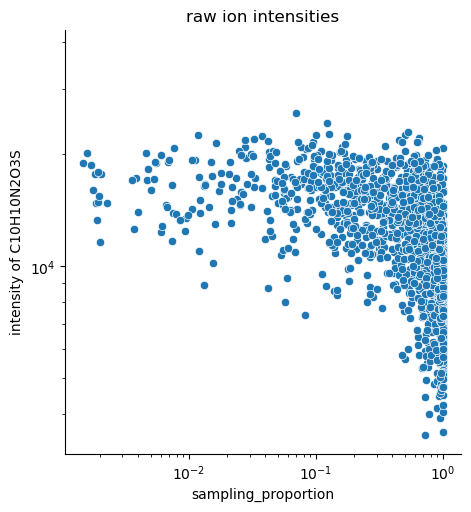

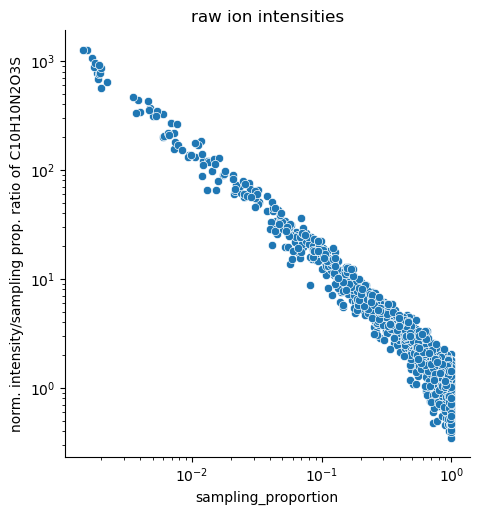

In [95]:

def normalize_proportion_ratios(raw_df, proportion_series = total_pixel_overlap, normalized = True, full_pixel_intensities = full_pixel_intensities):

    if(len(raw_df) != len(proportion_series) or len(raw_df.columns) != len(full_pixel_intensities)):
        print('normalize_proportion_ratios: Inconsistant size of arguments.')

    intensity_prop_ratios = raw_df.divide(proportion_series.replace(to_replace=0, value=np.nan), axis = 0)
    norm_intensity_prop_ratios = intensity_prop_ratios.divide(full_pixel_intensities, axis=1)
    


    if(normalized): return(norm_intensity_prop_ratios)
    else: return(intensity_prop_ratios)

def log_log_regression_plot(df, molecule = '', x_axis= total_pixel_overlap, x_axis_name='sampling_proportion', title = 'Regression plot'):
    intensities_df = df.copy()

    norm_intensity_prop_ratios_df = normalize_proportion_ratios(intensities_df, proportion_series=x_axis)
    intensities_df[x_axis_name] = total_pixel_overlap
    norm_intensity_prop_ratios_df[x_axis_name] = total_pixel_overlap

    if not molecule in intensities_df.columns:
        molecule = intensities_df.columns[0]

    def render_plot(df, measure):

        plot = sns.relplot(data=df.dropna(subset = [molecule, x_axis_name]).infer_objects(), x=x_axis_name, y=molecule)
        plot.set(xscale="log")
        plot.set(yscale="log")
        plot.set(ylabel= measure + " of " + molecule)
        plot.set(title=title)

    render_plot(intensities_df, measure = 'intensity')
    render_plot(norm_intensity_prop_ratios_df, measure = 'norm. intensity/sampling prop. ratio')


log_log_regression_plot(ion_intensities, title = 'raw ion intensities')

In [96]:
normalize_proportion_ratios(ion_intensities, proportion_series=total_pixel_overlap)

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
pixel_0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pixel_1,66.000901,54.386647,34.852720,66.258092,54.786971,81.536816,64.825046,61.458694,49.174895,60.926653,...,123.834583,46.386218,0.0,320.858216,365.970887,85.503724,0.0,85.268783,76.734358,84.729393
pixel_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pixel_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pixel_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pixel_2495,1.636635,1.444318,2.076957,1.457492,0.000000,1.430550,1.480068,1.470147,1.623836,1.690965,...,0.932893,1.317628,0.0,1.392648,0.000000,0.000000,0.0,1.261557,1.075937,1.045749
pixel_2496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pixel_2497,2.285817,2.805192,0.700181,5.654077,2.788597,1.266272,2.198390,2.217801,2.807030,2.522257,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.988608,1.390446,0.322343
pixel_2498,1.727717,1.993915,0.697641,2.711955,0.669837,1.127245,1.710992,1.850399,1.668777,1.955580,...,1.433185,1.433012,0.0,1.195622,0.000000,7.040619,0.0,1.789172,1.704552,0.910471


In [97]:
def quantreg(intensities_df, sampling_proportion_series, proportion_threshold = 0.1):
    
    reference = 'sampling_proportion'

    if len(intensities_df) != len(sampling_proportion_series):
        print('Quantreg: Inconsistent sizes of arguments')

    prop_ratio_df = normalize_proportion_ratios(raw_df=intensities_df, proportion_series=sampling_proportion_series)
    log_prop_series = np.log10(sampling_proportion_series)
    log_ratio_df = np.log10(prop_ratio_df.replace(np.nan, 0).infer_objects())
    log_ratio_df = log_ratio_df.replace([np.inf, - np.inf], np.nan)

    correction_factors = log_ratio_df.copy().applymap(lambda x: np.nan)
    params = {}
    predictions = log_ratio_df.copy().applymap(lambda x: np.nan)

    for ion in log_ratio_df.columns:
        df = pd.concat([log_ratio_df[ion], log_prop_series], axis=1)
        df_for_model = df[df.sampling_proportion > np.log10(proportion_threshold)].dropna()

        if len(df_for_model) < 3: print('skipping ' + ion); continue
        model = smf.quantreg(ion + ' ~ ' + reference, df_for_model)
        qrmodel = model.fit(q=0.5)
        params[ion] = qrmodel.params
        reg_correction = 10 ** qrmodel.predict(df)
        predictions[ion] = intensities_df[ion] / reg_correction
        correction_factors[ion] = reg_correction
    
    # print(pd.concat([ion_intensities['C16H30O2'], sampling_proportion_series, log_ratio_df['C16H30O2'], correction_factors['C16H30O2'], predictions['C16H30O2']], axis=1))

    return((correction_factors, pd.Series(params), predictions))


correction_factors, slopes, corrected_intensities = quantreg(ion_intensities, sampling_proportion_series=total_pixel_overlap)



/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


skipping C34H70NO6P


/Users/mariusklein/opt/anaconda3/envs/ion_suppression/lib/python3.7/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


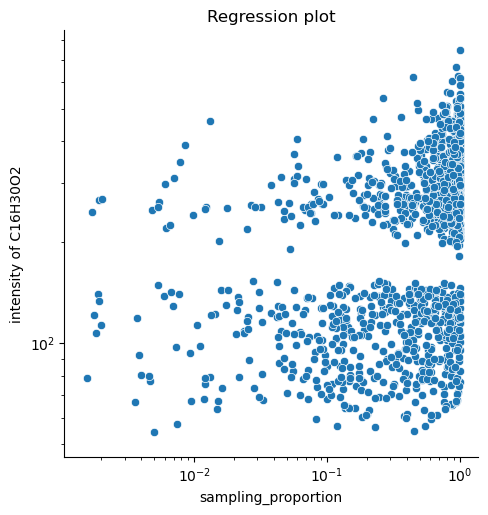

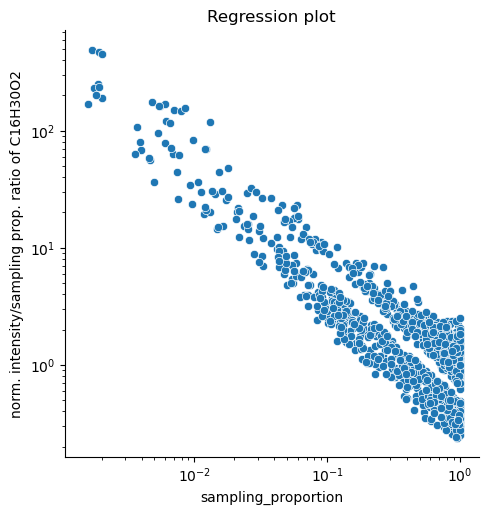

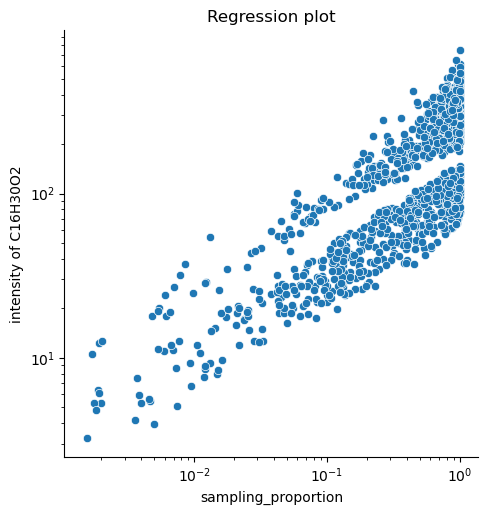

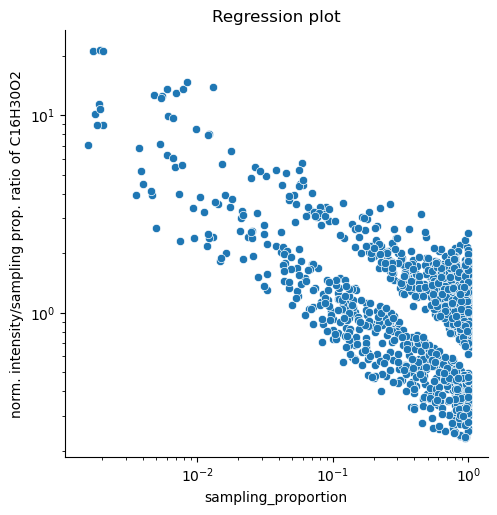

In [98]:
plot_intensities = ion_intensities.copy()
log_log_regression_plot(ion_intensities, molecule='C16H30O2')
log_log_regression_plot(corrected_intensities, molecule='C16H30O2')

In [101]:
norm_corr_ion_intensities = cell_normalization_Rappez_matrix(sampling_prop_matrix=sampling_prop_matrix, sampling_spec_matrix=sampling_spec_matrix, ion_intensity_matrix=corrected_intensities)
norm_corr_ion_intensities.dropna()

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_11,12610.991227,1265.266047,301.735285,122.255123,347.650584,1451.809816,550.238383,1071.574050,885.581829,1284.099418,...,0.000000,0.000000,0.0,0.000000,59.091746,0.000000,0.0,1789.460259,1084.711656,86.295833
cell_13,14673.705354,1477.399504,204.715505,172.932051,366.247302,1274.702180,627.487881,1204.039600,1133.438408,1688.937606,...,0.000000,116.394060,0.0,0.000000,29.360439,0.000000,0.0,1556.000265,1015.623651,42.877114
cell_14,10976.910197,1635.839781,0.000000,202.066775,218.740145,1205.105475,857.272606,900.005566,827.694763,1120.512357,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2440.611936,1051.902339,196.507837
cell_15,16546.902158,1661.308344,121.270923,215.241475,374.963024,1091.730225,702.520286,1328.023521,1367.417293,2059.884233,...,0.000000,220.820936,0.0,0.000000,0.000000,0.000000,0.0,1365.574190,949.001913,6.956724
cell_16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1500,10153.034811,1001.081918,160.949594,116.433174,175.478382,1169.047017,784.662524,1284.564676,731.352331,1529.750821,...,79.978215,189.227309,0.0,47.206809,136.641402,0.000000,0.0,3501.403290,2182.346826,198.588089
cell_1503,16422.942695,1524.874347,299.427510,196.545154,173.008005,1366.777887,1240.732731,1549.878134,1182.231034,2574.047877,...,25.398547,166.771084,0.0,0.000000,0.000000,0.000000,0.0,3983.420848,2064.836883,178.200168
cell_1510,8798.704252,795.483540,72.590768,0.000000,51.170792,1172.811343,632.769678,830.147902,263.869523,1383.043902,...,242.504969,219.275742,0.0,474.201736,0.000000,112.306402,0.0,8656.873532,3566.693414,820.576592
cell_1512,8931.510002,819.796651,83.915011,14.825120,65.803373,1172.808342,652.262030,884.363685,317.542808,1395.390003,...,215.193730,208.538891,0.0,420.796492,18.660362,99.658302,0.0,8074.988330,3421.108336,745.471289


In [107]:
norm_ion_intensities.to_pickle('data/Mx_Co_Cultured/normalized_ion_intensities.pkl')
norm_corr_ion_intensities.to_pickle('data/Mx_Co_Cultured/normalized_corrected_ion_intensities.pkl')

In [108]:
norm_ion_intensities

,C10H10N2O3S,C10H10N2O4S,C12H13N3O4S,C12H20N3O6S,C13H16N2O5,C13H26O2,C14H20N2O3S,C14H20N2O4S,C14H20N2O6S,C14H21N3O3S,...,C45H78NO8P,C45H80NO8P,C45H82NO7P,C45H82NO8P,C46H77O10P,C46H81NO10P,C50H84NO10P,C6H11O8P,C6H13O9P,C9H19O11P
cell_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cell_1573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
